In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests, glob, Augmentor, os, json, pickle, matplotlib, keras, sklearn, GPUtil
from zipfile import ZipFile
import tensorflow as tf

from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Activation, Dropout, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19, preprocess_input
from keras import optimizers
from keras import backend as K

from keras.callbacks import TensorBoard
from keras.callbacks import TerminateOnNaN
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras.callbacks import History

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Versions

print('Versions')
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Tensorflow:', tf.__version__)
print('Keras:', keras.__version__)
print('Sklearn:', sklearn.__version__)

Versions
Numpy: 1.14.2
Matplotlib: 2.2.2
Tensorflow: 1.7.0
Keras: 2.1.5
Sklearn: 0.19.1


In [3]:
def download_file(url, out_file):
    chunk_size = 1024
    r = requests.get(url, stream=True)
    total_size = int(r.headers['content-length'])
    with open(out_file, 'wb') as f:
        for data in tqdm(iterable=r.iter_content(chunk_size=chunk_size),
                         total=total_size/chunk_size, unit='KB'):
            f.write(data)
    print('{} download Complete!'.format(out_file))

def extract_zipfile(data_path, zip_file):
    if not os.path.isdir(data_path):
        with ZipFile(zip_file, 'r') as f:
            print('Extracting all the files now ...')
            f.extractall(data_path)
            print('Done!')

def explore_data(data_path, labels_list):
    images_count = []
    X = []
    y = []
    plt.figure(1)
    print('No of images in:')
    for idx, label in enumerate(labels_list):
        label_path = os.path.join(data_path, label)
        images_list = glob.glob(os.path.join(label_path, '*.png'))
        num_images = len(images_list)
        images_count.append(num_images)
        X += images_list
        y += [label] * num_images
        img_path = images_list[0]
        img = plt.imread(img_path)

        plt.subplot(3,4,idx+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        print('{} directory: {}'.format(label, num_images))
    print()
    plt.show()
    return images_count, X, y

def plot_histogram(y):
    plt.hist(y, bins=86)
    plt.xlabel('labels')
    plt.ylabel('no of images')
    plt.show()

def augment_images(path, num, avg_img):
    p = Augmentor.Pipeline(path, '.', save_format='png')
    p.random_brightness(.5, .25, .75)
    p.random_color(.5, .25, .75)
    p.random_contrast(.5, .25, .75)
    p.rotate(.5, 10, 10)
    p.sample(avg_img - num)

def add_dicts(d, e):
    for key in e.keys():
        if key not in d:
            d[key] = e[key]
        else:
            d[key] += e[key]
    return d

def plot_metrics(d):
    plots = [i for i in d.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))
    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i+1)
        plt.title(p)
        plt.plot(d[p], label=p)
        plt.plot(d['val_'+p], label = 'val_'+p)
        plt.legend()
    plt.show()

def precision(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    fp = K.sum(y_pred * K.cast(K.equal(y_true, K.zeros_like(y_true)), "float32"))
    return tp / (tp + fp + K.epsilon())

def recall(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * K.cast(K.equal(y_pred, K.zeros_like(y_pred)), "float32"))
    return tp / (tp + fn + K.epsilon())

def f1(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.one_hot(y_pred, 12)
    pm = precision(y_true, y_pred)
    rm = recall(y_true, y_pred)
    return (2 * pm * rm) / (pm + rm + K.epsilon())

def get_callbacks():
    # TerminateOnNaN
    terminate_callback = TerminateOnNaN()
    # Tensorboard
    tb_callback = TensorBoard('./Graph', histogram_freq=0,
                    write_graph=True, write_images=True)
    # Model Checkppoint
    ckpt_callback = ModelCheckpoint('./output_data/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                    verbose=1, save_weights_only=False,
                                    mode='auto', period=5)
    # CSV Logger
    csv_logger = CSVLogger('./training.log')
    # History
    hist = History()
    # Callbacks list
    callbacks = [terminate_callback, tb_callback, ckpt_callback,
                 csv_logger, hist]
    return callbacks

def data_generator(X, y, batch_size):
    idx = 0
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)
    num_batches = len(X)//batch_size
    while True:
        start = idx * batch_size
        end = start + batch_size
        batch_X = []
        batch_y = y[start:end, :]
        for filename in X[start:end]:
            img = image.load_img(filename, target_size=(299, 299, 3))
            img = image.img_to_array(img)
            batch_X.append(img)
        batch_X = np.array(batch_X)
        batch_X = preprocess_input(batch_X)
        batch_X /= 255
        idx += 1
        yield batch_X, batch_y
        if idx == num_batches:
            idx = 0

def get_data(data_file):
    data = {}
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    return data['X'], data['y'], data['X_valid'], data['y_valid'], data['X_test'], data['y_test']


def get_vgg19(lr, beta_1, beta_2, epsilon, decay):
    # Load model
    # include_top is used to remove all the layers after block conv5
    name = 'vgg19'
    model = VGG19(include_top=False, input_shape=(299, 299, 3))
    # Freeze all layers
    for layer in model.layers:
        layer.trainable = False
    # re-add the removed layers
    x = model.output
    x = Flatten(name="flatten")(x)
    x = Dense(4096, activation="relu", name="fc1")(x)
    x = Dense(4096, activation="relu", name="fc2")(x)
    x = Dense(num_labels, activation="softmax", name="predictions")(x)
    # Redefine the model
    model = Model(inputs=model.input, outputs=x, name="final_model")
    model.summary()
    adam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2,
                           epsilon=epsilon, decay=decay)
    # compile the model
    model.compile(optimizer=adam, loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall,
              f1])
    return model, name

def get_cnn(lr, beta_1, beta_2, epsilon, decay, num_conv_layers):
    name = 'cnn'
    n_kernels = [128] * num_conv_layers
    mp_sizes = [(2,2) for _ in range(num_conv_layers)]
    dropout_values = [0.25] * num_conv_layers

    model = Sequential()
    model.add(BatchNormalization(axis=3, input_shape=(299, 299, 3)))
    for i in range(num_conv_layers):
        model.add(Conv2D(n_kernels[i], (3, 3), padding="same", kernel_initializer="he_uniform"))
        model.add(BatchNormalization(axis=3))
        model.add(Activation('relu'))
        if i < num_conv_layers - 1:
            model.add(Dropout(dropout_values[i]))

    model.add(Conv2D(12, (3, 3), padding="same"))
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))
    model.compile(optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
    model.summary()

    return model, name

def cross_valid_train(X, y, n_splits, batch_size, epochs, name, 
                      output_path, model):
    GPUtil.showUtilization()
    cross_model_path = os.path.join(output_path,
                                'plant_{}_cross.h5'.format(name))
    ## Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True,
                            random_state=0)
    histories = {}
    if not os.path.isfile(cross_model_path):
        # Training
        print("Start cross-validation training...")
        temp_X = np.array(X)
        temp_y = np.array(y)
        for train, val in skf.split(temp_X, temp_y):
            train_datagen = data_generator(temp_X[train], temp_y[train],
                                            batch_size)
            valid_datagen = data_generator(temp_X[val], temp_y[val],
                                            batch_size)
            history = model.fit_generator(train_datagen,
                            steps_per_epoch=len(train)//batch_size,
                            validation_data=valid_datagen, epochs=epochs,
                            validation_steps=len(val)//batch_size)
            histories = add_dicts(histories, history.history)
        model.save(cross_model_path)
        del model
        with open('cross_train_{}.pkl'.format(name), 'wb') as f:
            pickle.dump(histories, f)
    else:
        with open('cross_train_{}.pkl'.format(name), 'rb') as f:
            histories = pickle.load(f)
    return histories, cross_model_path

def full_train(X, y, X_valid, y_valid, X_test, y_test, name,
                output_path, cross_model_path, batch_size, epochs, 
                callbacks, histories):
    GPUtil.showUtilization()
    ## Full Training
    full_model_path = os.path.join(output_path, 'plant_{}.h5'.format(name))
    model = load_model(cross_model_path, custom_objects={'f1':f1,
                                    'precision':precision,'recall':recall})
    if not os.path.isfile(full_model_path):
        print("Full training...")
        train_datagen = data_generator(X, y, batch_size)
        valid_datagen = data_generator(X_valid, y_valid, batch_size)
        history = model.fit_generator(train_datagen,
                            steps_per_epoch=len(X)//batch_size,
                            epochs=epochs, callbacks = callbacks,
                            validation_data=valid_datagen,
                            validation_steps=len(X_valid)//batch_size)
        histories = add_dicts(histories, history.history)
        print("Save whole model...")
        model.save(full_model_path)
        with open('full_train.pkl', 'wb') as f:
            pickle.dump(histories, f)
    else:
        with open('full_train.pkl', 'rb') as f:
            histories = pickle.load(f)

    return histories, full_model_path

def evaluate(X_test, y_test, batch_size, full_model_path):
    ## Evaluate
    batch_size = 32
    model = load_model(full_model_path, custom_objects={'f1':f1,
                                'precision':precision,'recall':recall})
    test_datagen = data_generator(X_test, y_test, batch_size)
    Eval = model.evaluate_generator(test_datagen,
                            steps = len(X_test)//batch_size, workers=12)
    print(Eval)

In [4]:
url = 'https://vision.eng.au.dk/?download=/data/WeedData/NonsegmentedV2.zip'
zip_file = './data.zip'
data_path = './data'

if not os.path.isfile(zip_file):
    download_file(url, zip_file)

In [5]:
ls

cross_train_vgg19.pkl  data.pkl        Graph/                 training.log
data/                  data.zip        output_data/
data_copy/             full_train.pkl  Plant Seedlings.ipynb


In [6]:
extract_zipfile(data_path, zip_file)

In [7]:
ls

cross_train_vgg19.pkl  data.pkl        Graph/                 training.log
data/                  data.zip        output_data/
data_copy/             full_train.pkl  Plant Seedlings.ipynb


In [8]:
ls data/

Black-grass/  Common Chickweed/  Loose Silky-bent/   Shepherd’s Purse/
Charlock/     Common wheat/      Maize/              Small-flowered Cranesbill/
Cleavers/     Fat Hen/           Scentless Mayweed/  Sugar beet/


In [9]:
labels_list = os.listdir(data_path)
num_labels = len(labels_list)

print('Labels:')

for idx, label in enumerate(labels_list):
    print('{}. {}'.format(idx+1, label))

Labels:
1. Shepherd’s Purse
2. Cleavers
3. Maize
4. Fat Hen
5. Black-grass
6. Charlock
7. Sugar beet
8. Small-flowered Cranesbill
9. Common wheat
10. Loose Silky-bent
11. Scentless Mayweed
12. Common Chickweed


No of images in:
Shepherd’s Purse directory: 274
Cleavers directory: 335
Maize directory: 257
Fat Hen directory: 538
Black-grass directory: 309
Charlock directory: 452
Sugar beet directory: 463
Small-flowered Cranesbill directory: 576
Common wheat directory: 253
Loose Silky-bent directory: 762
Scentless Mayweed directory: 607
Common Chickweed directory: 713



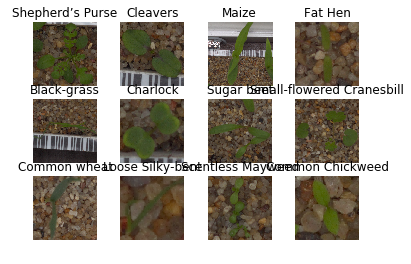

In [10]:
images_count, _, y = explore_data(data_path, labels_list)

In [11]:
avg_img = sum(images_count)//len(images_count)

print(avg_img)

461


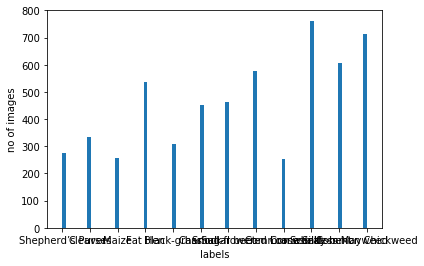

In [12]:
plot_histogram(y)

In [13]:
from subprocess import call

if not os.path.isdir('./data_copy'):
    _ = call(['cp', '-a', data_path, './data_copy'])

data_path = './data_copy'

In [14]:
ls

cross_train_vgg19.pkl  data.pkl        Graph/                 training.log
data/                  data.zip        output_data/
data_copy/             full_train.pkl  Plant Seedlings.ipynb


In [15]:
if len(os.listdir('./data_copy/Black-grass')) < avg_img+1:    
    for label in labels_list:
        label_path = os.path.join(data_path, label)
        images_list = os.listdir(label_path)
        if len(images_list) < avg_img:
            augment_images(label_path, len(images_list), avg_img) 

No of images in:
Shepherd’s Purse directory: 461
Cleavers directory: 461
Maize directory: 461
Fat Hen directory: 538
Black-grass directory: 461
Charlock directory: 461
Sugar beet directory: 463
Small-flowered Cranesbill directory: 576
Common wheat directory: 461
Loose Silky-bent directory: 762
Scentless Mayweed directory: 607
Common Chickweed directory: 713



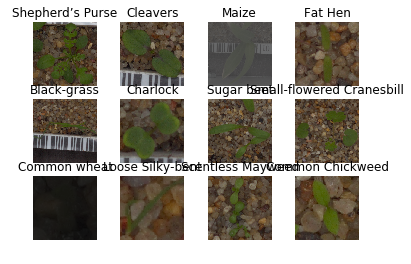

In [16]:
_, X, y = explore_data(data_path, labels_list)

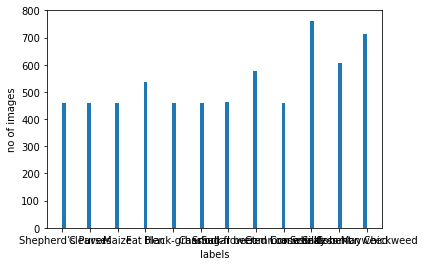

In [17]:
plot_histogram(y)

In [18]:
## Split data

X, y = shuffle(X, y)

X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.1,
                                          random_state=0, stratify=y)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=0, stratify=y)

print('Train:', len(X), len(y))
print('Valid:', len(X_valid), len(y_valid))
print('Test:', len(X_test), len(y_test))

data = {'X': X, 'y': y, 'X_valid': X_valid, 'y_valid': y_valid, 
           'X_test': X_test, 'y_test': y_test}

with open('./data.pkl', 'wb') as f:
    pickle.dump(data, f)

Train: 4625 4625
Valid: 643 643
Test: 1157 1157


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

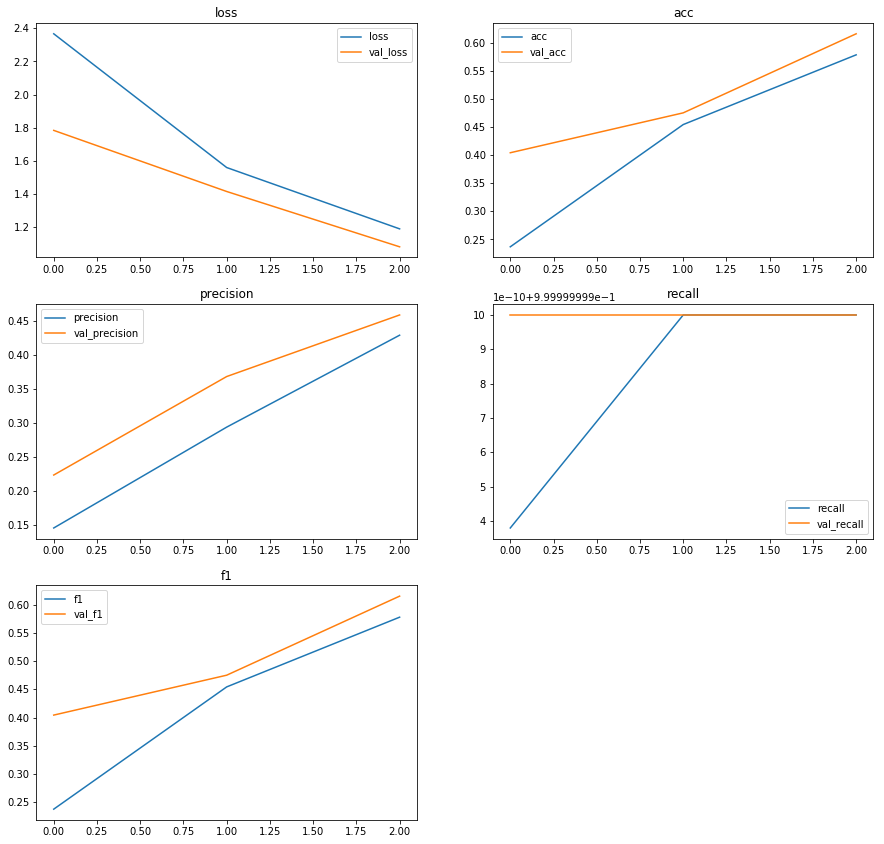

Instructions for updating:
Use the retry module or similar alternatives.
| ID | GPU | MEM |
------------------
|  0 |  3% | 95% |


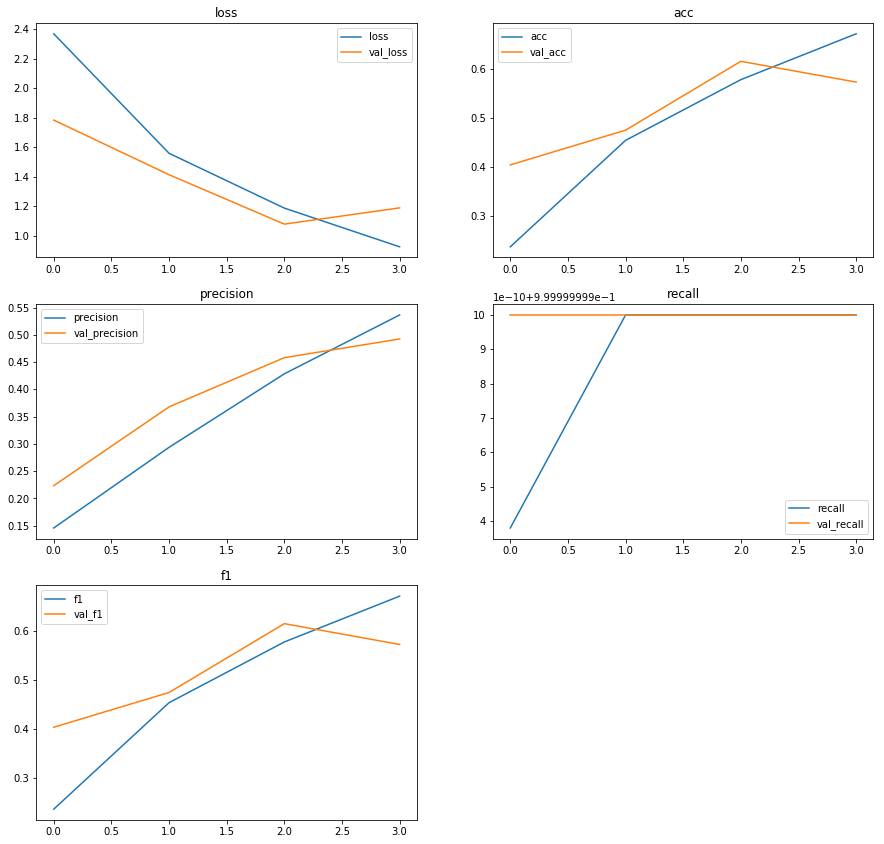

[0.9260583072900772, 0.6770833333333334, 0.5618256595399644, 1.0, 0.6770832737286886]


In [19]:
# VGG19

n_splits = 3
batch_size = 32
epochs = 1 #10

lr = 0.0001
beta_1=0.9
beta_2=0.999
epsilon=1e-08
decay=0.0

data_file = './data.pkl'
output_path = './output_data'
log_file = os.path.join(output_path, 'log.csv')
if not os.path.exists(output_path):
    os.makedirs(output_path)

vgg_model, name = get_vgg19(lr, beta_1, beta_2, epsilon, decay)

X, y, X_valid, y_valid, X_test, y_test = get_data(data_file)

histories, cross_model_path = cross_valid_train(X, y, n_splits, 
                         batch_size, epochs, name, output_path, vgg_model)

plot_metrics(histories)

callbacks = get_callbacks()

batch_size = 32
epochs = 1 #20

histories, full_model_path = full_train(X, y, X_valid, y_valid, X_test,
                            y_test, name, output_path, cross_model_path,
                            batch_size, epochs, callbacks, histories)

plot_metrics(histories)

evaluate(X_test, y_test, batch_size, full_model_path)

In [20]:
ls

cross_train_vgg19.pkl  data.pkl        Graph/                 training.log
data/                  data.zip        output_data/
data_copy/             full_train.pkl  Plant Seedlings.ipynb


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 299, 299, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 128)     3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 299, 299, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 299, 299, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 299, 299, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 128)     147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 299, 299, 128)     512       
__________

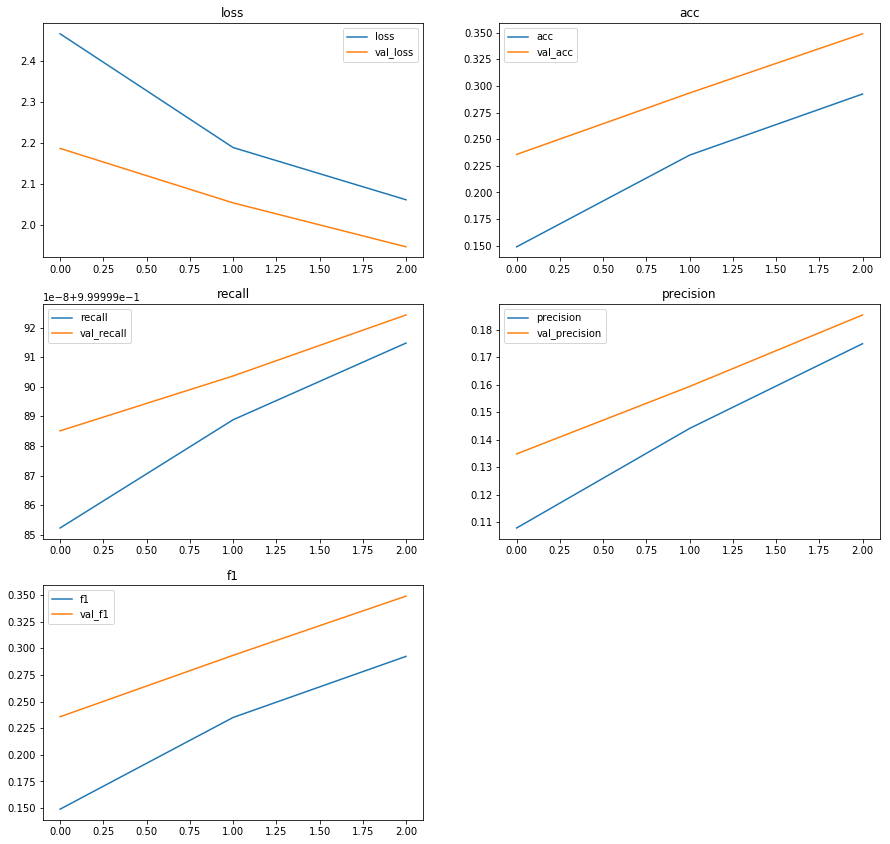

| ID | GPU | MEM |
------------------
|  0 |  3% | 96% |
Full training...
Epoch 1/1
578/578 [==============================] - 264s 458ms/step - loss: 1.9708 - acc: 0.3237 - recall: 1.0000 - precision: 0.1993 - f1: 0.3237 - val_loss: 1.8604 - val_acc: 0.3812 - val_recall: 1.0000 - val_precision: 0.2284 - val_f1: 0.3812
Save whole model...


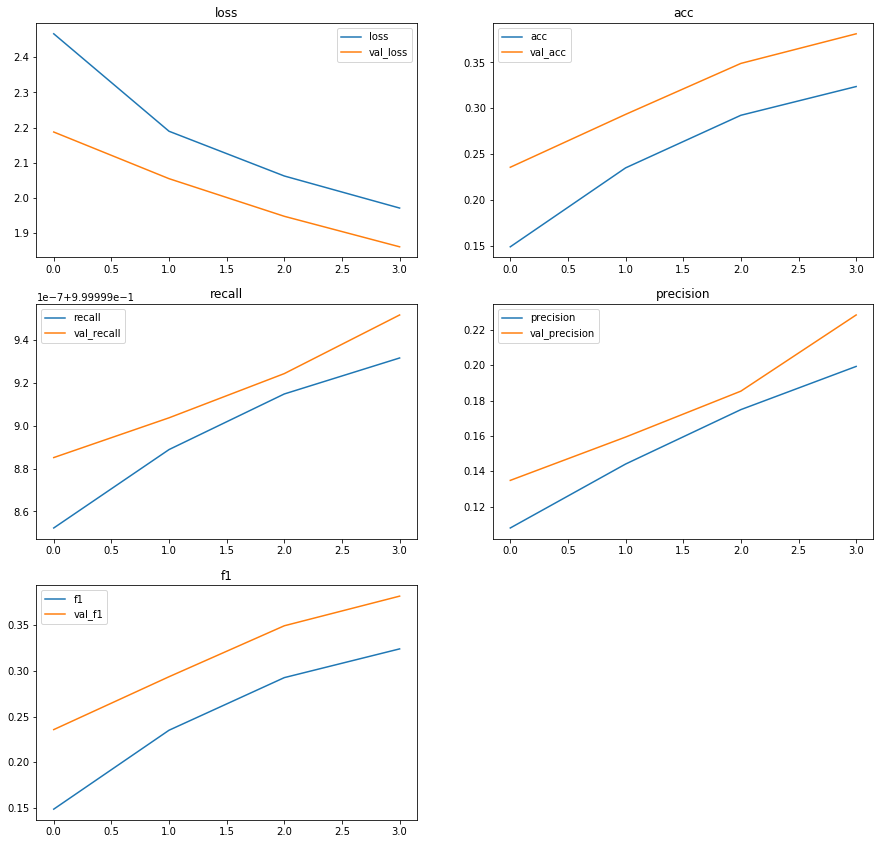

[1.832588212357627, 0.4175347222222222, 1.0, 0.2340368533300029, 0.41753466261757743]


In [21]:
# CNN

n_splits = 3
batch_size = 8
epochs = 1 #10
num_conv_layers = 3

lr = 0.001
beta_1=0.9
beta_2=0.999
epsilon=1e-08
decay=0.0

data_file = './data.pkl'
output_path = './output_data'
log_file = os.path.join(output_path, 'log.csv')
if not os.path.exists(output_path):
    os.makedirs(output_path)

cnn_model, name = get_cnn(lr, beta_1, beta_2, epsilon, decay, num_conv_layers)

X, y, X_valid, y_valid, X_test, y_test = get_data(data_file)

histories, cross_model_path = cross_valid_train(X, y, n_splits,
                                                batch_size, epochs, name,
                                                output_path, cnn_model)

plot_metrics(histories)

callbacks = get_callbacks()

batch_size = 8
epochs = 1 #20

histories, full_model_path = full_train(X, y, X_valid, y_valid, X_test,
                            y_test, name, output_path, cross_model_path,
                            batch_size, epochs, callbacks, histories)

plot_metrics(histories)

evaluate(X_test, y_test, batch_size, full_model_path)

In [22]:
ls

cross_train_cnn.pkl    data_copy/  full_train.pkl  Plant Seedlings.ipynb
cross_train_vgg19.pkl  data.pkl    Graph/          training.log
data/                  data.zip    output_data/
